# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

last modification : 28-07-21

### Loading libs

In [2]:
current_dir <- getwd()
mogp_dir <- paste0(current_dir, "/mogp-emulator") #mogp_emulator lib

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/'))

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

L96_amip <- import("L96_amip")
np <- import("numpy")
smt <- import("smt")
sklearn <- import("sklearn")
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

packages <- c("FactoMineR", "factoextra", "corrplot", 'kernlab', 'pca3d', 'BBmisc', 'comprehenr', 'caret', "future.apply", 'tgp', 'ANN2', 'ramify', 'MLmetrics', 'keras')
# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [8]:
save_data <- FALSE
load_data <- TRUE
data_path <- paste0(current_dir, "/data/") 
if (load_data){
    list.files(data_path)
}

[1] "Inputs_wave1-2021-07-29-iters40-samples40.csv" 
[2] "Inputs_wave1-2021-07-30-iters40-samples40.csv" 
[3] "Metrics_wave1-2021-07-29-iters40-samples40.csv"
[4] "Metrics_wave1-2021-07-30-iters40-samples40.csv"
[5] "Observations-2021-07-29-iters40.csv"           
[6] "Observations-2021-07-30-iters40.csv"

In [19]:
if(load_data){
    obs_file <- paste0(data_path, "Observations-2021-07-29-iters40.csv")
    inputs_file <- paste0(data_path, "Inputs_wave1-2021-07-29-iters40-samples40.csv")
    metrics_file <- paste0(data_path, "Metrics_wave1-2021-07-29-iters40-samples40.csv")
    observations <- t(read.csv(obs_file))
    inputs_wave1 <- read.csv(inputs_file)
    metrics_wave1 <- read.csv(metrics_file)
}

In [4]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [5]:
l96_two$iterate(10)

In [6]:
X_init = l96_two$X

We can use *Newinit* to be sure to start from the attractor of the L96.

In [7]:
np$random$seed(as.integer(42))
n_iter <- 40 
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=X_init, integration_type='coupled') 

In [8]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

We save the metrics generate with the ground truth parameters (observations).

In [9]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0), amip_metrics=FALSE))

   user  system elapsed 
  0.604   0.092   0.696 

In [10]:
if(save_data) {
    observations_file_name <- paste0("Observations-", Sys.Date(), "-iters", n_iter, ".csv")
    write.csv(observations,paste0(data_path,observations_file_name), row.names = FALSE)
}

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [11]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [12]:
n_samples <- 40

In [13]:
space <- skSpace$Space(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Sobol()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

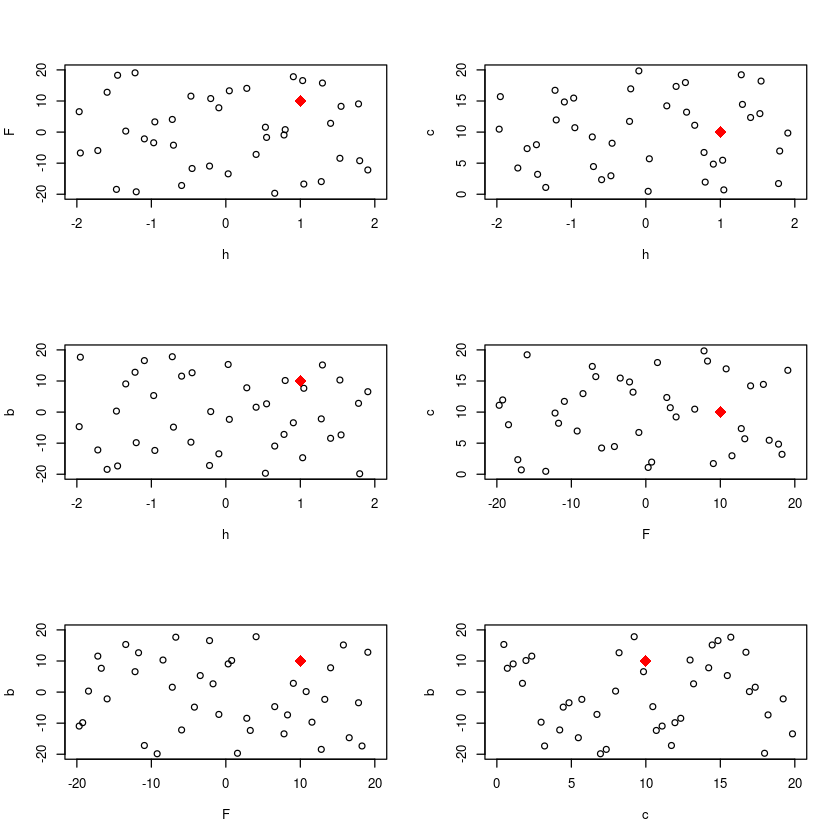

In [14]:
par(mfrow=c(3,2))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)

plot(inputs_wave1[,2], inputs_wave1[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

plot(inputs_wave1[,3], inputs_wave1[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [15]:
extract_metrics <- function(p, n_iter, dt, X_init) {
    l96_mip = L96_amip$L96TwoLevel(X_init=X_init, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=p[[2]], c=p[[3]], b=p[[4]])
    l96_mip$iterate(n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0), amip_metrics=FALSE))
}

In [ ]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics(inputs_wave1[r,], n_iter, 0.001, X_init), future.seed=NULL) 

In [ ]:
if(save_data) {
    inputs_file_name <- paste0("Inputs_wave1-", Sys.Date(), "-iters", n_iter, "-samples", n_samples, ".csv")
    metrics_file_name <- paste0("Metrics_wave1-", Sys.Date(), "-iters", n_iter, "-samples", n_samples, ".csv")
    write.csv(inputs_wave1,paste0(data_path,inputs_file_name), row.names = FALSE)
    write.csv(metrics_wave1,paste0(data_path,metrics_file_name), row.names = FALSE)
}

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [10]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [22]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'F', 'c', 'b')


metrics_wave1 <- data.frame(metrics_wave1)
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,F,c,b,Noise,X1,X2,X3,X4,X5,⋯,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.12136064,-0.002948360,-1.0103606,-0.0468645789,0,-0.9121053,-0.16622816,-1.045345,-0.023311545,-1.070141,⋯,0.0010322725,0.0016761856,0.0013854935,0.001987499,0.0017001282,0.0012458986,0.0017205144,0.0008764292,0.0021961162,0.0012986973
2,0.37487011,-0.024451389,-1.0404097,0.0376435170,0,-1.9811903,-0.90080041,-1.725122,-0.937011676,-1.966982,⋯,0.0476602820,0.0513012576,0.0497117503,0.038620548,0.0541051052,0.0417039613,0.0554870846,0.0368591235,0.0485285859,0.0448680344
3,-0.31524484,0.024450505,-1.0208957,-0.0437881626,0,2.7177362,2.33451458,2.506643,2.681776701,2.235310,⋯,0.0637340503,0.0703107040,0.0745679670,0.058312996,0.0634207032,0.0663067865,0.0623733174,0.0683051528,0.0641041482,0.0625799700
4,-0.44470957,0.028617260,-0.9377863,-0.0493007854,0,2.3232883,2.14019548,2.197988,2.327148262,2.191088,⋯,0.0787015725,0.0764889007,0.0715139778,0.080167921,0.0763855390,0.0716020633,0.0783105104,0.0760389278,0.0736328406,0.0793262994
5,-0.28155694,-0.015335092,-1.0184164,0.0009603711,0,-2.3854823,-0.03932007,-2.322594,0.001455577,-2.311716,⋯,0.0759933444,0.0041077593,0.0751726817,0.008095052,0.0833861867,0.0043048368,0.0849719204,0.0078560533,0.0773196669,0.0177162701
6,-0.02662143,-0.008009001,-0.9567933,0.0327958252,0,-1.3331170,-0.15988486,-1.409417,-0.059159783,-1.385646,⋯,0.0003117383,0.0001848949,0.0003195917,0.000329123,0.0003707704,0.0001640687,0.0003344311,0.0001619515,0.0003652059,0.0002469295


### Training emulator

In [23]:
cands <- names(tData)[1:4]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_wave1), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 1.60106095505801 using F"
[1] "Max reduction is 0.0231516940697403 using h"
[1] "Max reduction is 0.00961203496255381 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ F + h + c + I(h * F) + I(c * F) + I(c * h), 
    data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.38368 -0.40275 -0.05649  0.43398  1.55399 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -0.06771    2.31620  -0.029   0.9769  
F            -65.88466   73.74900  -0.893   0.3781  
h              4.13808    8.92277   0.464   0.6459  
c             -0.35894    2.31638  -0.155   0.8778  
I(h * F)     -40.06554   15.93050  -2.515   0.0170 *
I(c * F)    -144.57832   74.13755  -1.950   0.0597 .
I(c * h)       3.59439    8.87128   0.405   0.6880  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7594 on 33 degrees of freedom
Multiple R-squared:  0.9148,	Adjusted R-squared:  0.89

We can use Leave One Out to verify if our GPs fit our metrics correctly.

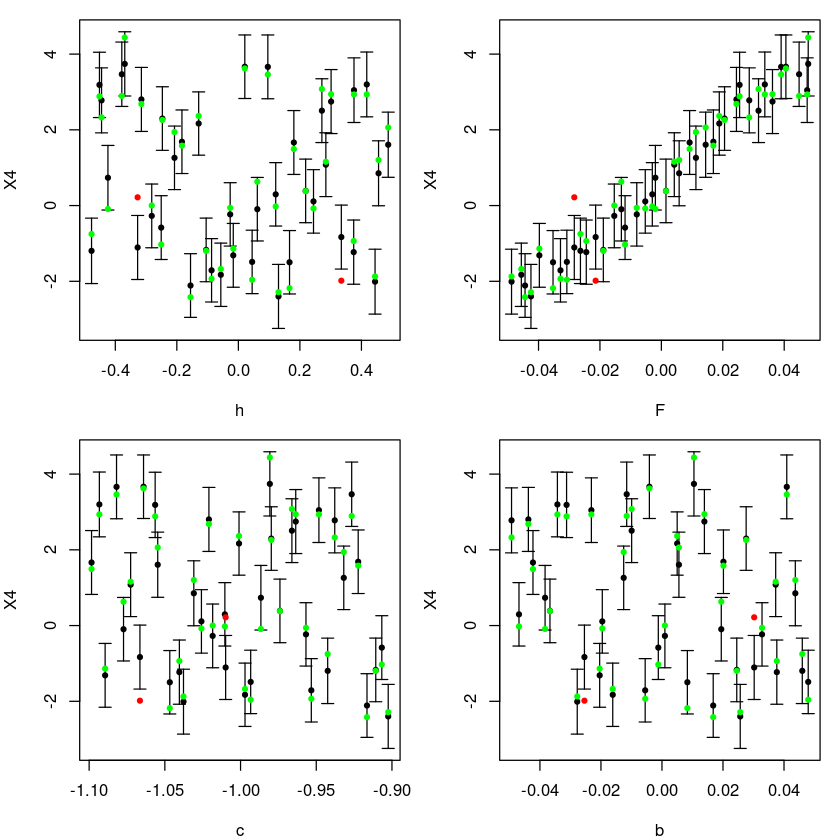

In [24]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 4, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [25]:
tDisc <- rep(0, ncol(metrics_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [26]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

Warning message in mccollect(jobs = jobs, wait = TRUE):
“1 parallel job did not deliver a result”


ERROR: Error: Failed to retrieve the result of MulticoreFuture (future_sapply-7) from the forked worker (on localhost; PID 15631). Post-mortem diagnostic: No process exists with this PID, i.e. the forked localhost worker is no longer alive.


Timing stopped at: 126.1 25.2 74.75



In [ ]:
VarNames <- names(Xp)
valmax = 3 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),F=c(10),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

In [ ]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

### Layout of NROY space

In [ ]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [31]:
if(load_data){
    inputs_file <- paste0(data_path, "Inputs_wave2-2021-07-28-iters50-samples40.csv")
    metrics_file <- paste0(data_path, "Metrics_wave2-2021-07-28-iters50-samples40.csv")
    inputs_wave2 <- read.csv(inputs_file)
    metrics_wave2 <- read.csv(metrics_file)
}

In [32]:
n <- ceiling(n_samples*1.3/scoreNROY1)

In [33]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [34]:
parameters_space <- function(emulators, NewData, n_samples=n_samples){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [35]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 40)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [36]:
input_wave2_scaled <- inputs_wave2_scaled_temp[NROY_temp_wave2,]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

In [38]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics(input_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL) 

In [1]:
if(save_data) {
    inputs_file_name <- paste0("Inputs_wave2-", Sys.Date(), "-iters", n_iter, "-samples", n_samples, ".csv")
    metrics_file_name <- paste0("Metrics_wave2-", Sys.Date(), "-iters", n_iter, "-samples", n_samples, ".csv")
    write.csv(inputs_wave1,paste0(data_path,inputs_file_name), row.names = FALSE)
    write.csv(metrics_wave1,paste0(data_path,metrics_file_name), row.names = FALSE)
}

ERROR: Error in eval(expr, envir, enclos): object 'save_data' not found


### Create the data matrix

In [ ]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'F', 'c', 'b')


metrics_wave2 <- data.frame(t(metrics_wave2))
N = nrow(metrics_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

### Training emulator

In [ ]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

In [ ]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [ ]:
n <- ceiling(n_samples*1.6/scoreNROY2)

In [ ]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, n_samples=40)

In [ ]:
length(NROY_temp_wave3)

In [ ]:
input_wave3_scaled <- inputs_wave3_scaled_temp[NROY_temp_wave3,]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0)
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

### Training emulator

In [ ]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

In [ ]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [ ]:
n <- ceiling(n_samples*4/scoreNROY3)

In [ ]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
emulators <- list(em_wave1, em_wave2, em_wave3)
NROY_temp_wave4 <- parameters_space(emulators, inputs_wave4_scaled_temp, 30)

In [ ]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

### Training emulator

In [ ]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

In [ ]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)